# PCA of metabolic fluxes to analyze variance in AGP

(B) Growth niche map for gut genera. Import fluxes for each genus in each sample were reduced to two dimensions using t-SNE. Each symbol denotes a genus in one sample and is colored and named by its genus. Genera that are close to each other consume similar sets of metabolites.(B) Growth niche map for gut genera. Import fluxes for each genus in each sample were reduced to two dimensions using t-SNE. Each symbol denotes a genus in one sample and is colored and named by its genus. Genera that are close to each other consume similar sets of metabolites.

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
## my functions/classes
from mb_xai import mb_utils
import mb_xai.gut_data as gd
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import Counter

def get_genus_exchange_df(X_df):
    """takes gut_data.fluxes as input. returns columns that are exchange reactions of specific genera"""
    medium_cols = [x for x in X_df.columns if "__medium" in x]
    genus_ex_fluxes = []
    for med_flux in medium_cols:
        ex_flux_id = med_flux.split("_m")[0]+"(e)"
        for col in X_df.columns:
            if ex_flux_id in col:
                genus_ex_fluxes.append(col)
    genus_ex_df = X_df[genus_ex_fluxes].copy()
    return genus_ex_df

def get_genus_exchange_longform(X_df):
    """takes gut_data.fluxes[genus exchange reactions] as input and converts genera exchange reaction df to long form"""
    genus_exchange_df_melt = X_df.copy()
    columns_vals = list(genus_exchange_df_melt.columns)
    genus_exchange_df_melt = genus_exchange_df_melt.reset_index()
    genus_exchange_df_melt = pd.melt(genus_exchange_df_melt, id_vars=['index'], value_vars=columns_vals)
    # genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].map(lambda x: x.split("__"))
    genus_exchange_df_melt[["react", "genus"]] = genus_exchange_df_melt["react"].str.split("__", expand=True) # ,
    return genus_exchange_df_melt

# DATA_LOC = '../../../Data/community_optimization/data/'
DATA_LOC = '../../../Data/microbiome_xai/'
# DATA_LOC = '../../Data/microbiome_xai/'

# FLUX_DF_NAME = "micom_medium-fluxes-top5-736_samples.csv"
FLUX_DF_NAME = "micom_medium-fluxes-top50-9285_samples_fd.csv"
# FLUX_DF_NAME = "micom_fluxes-top5-112_samples.csv" ## I usually take both
SAVE_FIG = True

genus_phylo_class_df = pd.read_csv(DATA_LOC+"agp_data/genus_phylo_class.csv",index_col=0)
genus_phylo_class_df["phylum"] = genus_phylo_class_df["phylum"].str.lower()
genus_phylo_class_df["class"] = genus_phylo_class_df["class"].str.lower()

gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_top50_fd.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    # FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/SILVA_genus_counts_fd.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
# ### Load flux dataframe
# X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False)
# X_flux.index = X_flux.index.astype(str)
## Load flux dataframe
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False) # dtype=np.float64
X_flux.index = X_flux.index.astype(str)
gut_data.fluxes = X_flux.copy()

Fixed EX_tDHNACOA(e)


In [1]:
FLUX_DF_NAME = "micom_fluxes-top5-112_samples.csv" ## I usually take both
X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, low_memory=False) # dtype=np.float64
X_flux.index = X_flux.index.astype(str)

exchange_notmedium = []
for col in X_flux.columns:
    if "EX_" in col: #and "__medium" not in col:
        # print(col)
        exchange_notmedium.append(col)
        
print(len(exchange_notmedium))
X_flux_exnotmedium = X_flux[exchange_notmedium].copy()
X_flux_exnotmedium.head()

NameError: name 'pd' is not defined

In [5]:
from tqdm import tqdm

In [7]:
len(gut_data.com_model.reactions)

110071

In [12]:
gut_data.com_model.reactions.get_by_id('EX_oaa_m')

Reaction identifier,EX_oaa_m
Name,oaa_m medium exchange
Memory address,0x07fa19f92da90
Stoichiometry,oaa_m <=> Oxaloacetate <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [13]:
gut_data.com_model.reactions.get_by_id('EX_q8(e)__veillonella')

Reaction identifier,EX_q8(e)__veillonella
Name,Ubiquinone-8 exchange
Memory address,0x07fa19f90cca0
Stoichiometry,q8[e]__veillonella <=> 0.02 q8_m Ubiquinone-8 <=> 0.02 Ubiquinone-8
GPR,
Lower bound,-100
Upper bound,1000.0


In [11]:
exchange_notmedium[-3:]

['EX_q8(e)__veillonella', 'EX_12dgr180(e)__veillonella', 'EX_oaa_m']

In [16]:
set(exchange_notmedium)-set(list(['EX_tDHNACOA(e)__lactobacillus']))

{'EX_dfdcytd(e)__lachnospiraceae',
 'EX_urea(e)__ruminococcus',
 'EX_mantr(e)__erysipelotrichaceae',
 'EX_eztmb_glc(e)__eubacterium',
 'EX_des_astzl_glc(e)__paraprevotella',
 'EX_cbz_glc(e)__streptococcus',
 'EX_3oh_dlor_glc(e)__enterococcus',
 'EX_3hphac(e)__bilophila',
 'EX_glcn(e)__parabacteroides',
 'EX_am14(e)__streptococcus',
 'EX_stg(e)__dysgonomonas',
 'EX_stys(e)__bacteroides',
 'EX_czp(e)__dialister',
 'EX_4oh_dcf_glc(e)__roseburia',
 'EX_glypro(e)__pseudomonas',
 'EX_zn2(e)__oscillibacter',
 'EX_ddca(e)__enterococcus',
 'EX_bz(e)__corynebacterium',
 'EX_7a_czp(e)__providencia',
 'EX_gal(e)__alistipes',
 'EX_nadp(e)__butyricicoccus',
 'EX_gmfl_mI(e)__prevotella',
 'EX_pydx(e)__dorea',
 'EX_eltr(e)__lachnospiraceae',
 'EX_sbt_D(e)__clostridium',
 'EX_pac(e)__bacteroides',
 'EX_pb(e)__acinetobacter',
 'EX_sucr(e)__bacteroides',
 'EX_hdca(e)__stenotrophomonas',
 'EX_xan(e)__acinetobacter',
 'EX_isoval(e)__blautia',
 'EX_arbt(e)__enterococcus',
 'EX_dad_2(e)__sutterella',
 'EX_tl

In [ ]:
'EX_tDHNACOA(e)__lactobacillus'

In [17]:
FLUX_DF_NAME = "micom_fluxes-top50-9285_samples_fd.csv" ## I usually take both

exchange_notmedium = []
for react in tqdm(gut_data.com_model.reactions):
    react_id = react.id
    react_name = react.name
    if "EX_" in react_id and "__medium" not in react_id and "medium exchange" not in react_name:
        # print(col)
        exchange_notmedium.append(react_id)
        
exchange_notmedium = list(set(exchange_notmedium)-set(list(['EX_tDHNACOA(e)__lactobacillus'])))
print(len(exchange_notmedium))

X_flux = pd.read_csv(gut_data.dir_sim_data+FLUX_DF_NAME,index_col=0, usecols=exchange_notmedium, low_memory=False) # dtype=np.float64
X_flux.index = X_flux.index.astype(str)

100%|██████████| 110071/110071 [00:00<00:00, 1017780.27it/s]


15236


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [2]:
def match_Xy_df(X_in_df, y_in_df):
    X_df, y_df = X_in_df.copy(), y_in_df.copy()
    """ Makes sure X_df and y_df have the same indices"""
    overlap = list(set(X_df.index).intersection(set(y_df.index)))
    X_df =  X_df.loc[overlap]
    y_df =  y_df.loc[overlap]
    return X_df, y_df

def plot_pca_fluxes(X, y, n_components=3, plot_comps=[0,1], target_names=["0", "1"]):
        """Fits and plots PCA of the two dimensions
        Plot_comps specifies which components to drop
        target_names correspond to [0, 1], default just the vegan
        """
        #X = self.fluxes
        #y = self.y_df

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        colors = ['darkorange', 'turquoise'] # "navy"
        print(pca.explained_variance_ratio_)
        for X_transformed, title in [(X_pca, "PCA")]:
            plt.figure(figsize=(4, 4))
            for color, i, target_name in zip(colors, [0,1], target_names):
                plt.scatter(X_transformed[y == i, plot_comps[0]], X_transformed[y == i, plot_comps[1]],
                            color=color, lw=2, label=target_name)

            plt.legend(loc="best", shadow=False, scatterpoints=1)
            # plt.axis([-1, 1, -1, 1])
        plt.show()
        return pca, X_pca

[0.0674043  0.03617451 0.03176093 0.03002464 0.02718723]


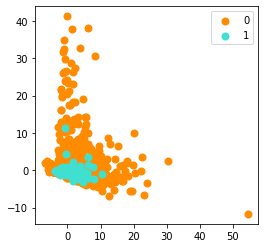

In [20]:
SAMPLE_NUM=10000
# input_type="flux"
input_type="abundance"
gut_data.set_vegan_df(sample_num=SAMPLE_NUM)
# gut_data.set_ibs_df(sample_num=SAMPLE_NUM, add_other_diagnosis=False)

# scaler = MinMaxScaler()
scaler = StandardScaler()
y_df = gut_data.y_df.copy()
if input_type=="flux":
    X, y = match_Xy_df(X_flux.copy(), y_df)
elif input_type=="abundance":
    X, y = match_Xy_df(gut_data.X_df.copy(), y_df)
X_scaled = scaler.fit_transform(X)
# pca, x_pca = plot_pca_fluxes(X_scaled, y, n_components=3, plot_comps=[0,1], target_names=["0", "1"])
pca, x_pca = plot_pca_fluxes(X_scaled, y, n_components=5, plot_comps=[0,1], target_names=["0", "1"])

In [ ]:
import dask.dataframe as dd

Try to load large csv using dask... (takes about 10minutes total to get wide form)

- Loading the dataframe is fast. The .cat.as_known() part takes the longest. also trying to save the wide form crashes...

In [ ]:
GENUS_FLUX_DF_NAME = "micom_medium-fluxes-genus-long-top50-9285_samples_fd.csv"
genus_exchange_df_wide = dd.read_csv(gut_data.dir_sim_data+GENUS_FLUX_DF_NAME)
# low_memory=False, partitions=1000)
genus_exchange_df_wide = genus_exchange_df_wide.set_index("Unnamed: 0")
genus_exchange_df_wide["sample_genus"] = genus_exchange_df_wide["index"] + "__" + genus_exchange_df_wide["genus"] 
genus_exchange_df_wide.drop_duplicates(subset=["sample_genus", "react"], keep='first', inplace=True)
genus_exchange_df_wide["react"] = genus_exchange_df_wide["react"].astype("category")
genus_exchange_df_wide["react"] = genus_exchange_df_wide["react"].cat.as_known()
genus_exchange_df_wide = dd.reshape.pivot_table(genus_exchange_df_wide, index='sample_genus', columns='react', values='value')

In [ ]:
genus_exchange_df_wide.shape

In [ ]:
genus_series_list = []
for x in genus_exchange_df_wide.index:
    genus_series_name = x.split("__")[1]
    genus_series_list.append(genus_series_name)

In [ ]:
genus_series = pd.Series(genus_series_list, index=genus_exchange_df_wide.index)

In [ ]:
genus_series = pd.Series(genus_exchange_df_wide.index.map(lambda x: x.split("__")[1]), index=genus_exchange_df_wide.index)
genus_series

In [ ]:
### THIS CRASHES THE NOTEBOOK
# genus_exchange_df_wide.to_csv(gut_data.dir_sim_data+"dask_dfs/genus_exchange_df_wide-*.csv")

In [ ]:
genus_exchange_df = get_genus_exchange_df(gut_data.fluxes)
genus_exchange_df_long = get_genus_exchange_longform(genus_exchange_df)
genus_exchange_df_long["sample_genus"] = genus_exchange_df_long["index"] + "__" + genus_exchange_df_long["genus"] 
genus_exchange_df_long.drop_duplicates(subset=["sample_genus", "react"], keep='first', inplace=True)
genus_exchange_df_wide = genus_exchange_df_long.pivot(index='sample_genus', columns='react', values='value')
genus_exchange_df_wide

In [ ]:
genus_series = pd.Series(genus_exchange_df_wide.index.map(lambda x: x.split("__")[1]), index=genus_exchange_df_wide.index)
genus_series

In [ ]:
X_flux.head()

# Compute fluxes (since necessary dataframes not generated yet)

In [ ]:
gut_data = gd.GutData()
gut_data.load_data(
    # FILE_COMM_MODEL='../data/reconstructions/community_5_TOP-vegan.pickle',
    FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_5_TOP-vegan.pickle',
    # FILE_COMM_MODEL= DATA_LOC + 'reconstructions/community_50_TOP.pickle',
    # FILE_GENUS_ASVS = "../data/agp_data/taxon_genus_asvs.csv",
    FILE_GENUS_ASVS = DATA_LOC + 'agp_data/taxon_genus_asvs.csv',
    # FILE_METADATA = DATA_LOC + "agp_data/mcdonald_agp_metadata.txt",
    FILE_METADATA = DATA_LOC + "agp_data/metadata_biosample_filtered.csv",
    DIR_SIM_DATA = DATA_LOC + "micom-sim-data/"  # "../data/micom-sim-data/",
)
gut_data.norm_abundances(filter_model=True, add_delta=True) ## Filters genus to those in model, adds small value to abundaces
gut_data.X_df = gut_data.asv_df.T.copy()
gut_data.sample_list = gut_data.X_df.index.to_list()
# gut_data.set_ibs_df(sample_num=20, add_other_diagnosis=False)
gut_data.set_vegan_df(sample_num=100)
## Set vegan df changes X_df and y_df and will therefore change medium_df. Be sure to run medium df after setting samples
medium_df = pd.DataFrame(1000, columns=gut_data.com_model.medium.keys(), index = gut_data.X_df.index)
gut_data.sample_medium_dict = medium_df.T.to_dict()
gut_data.return_fluxes = True
gut_data.pfba_bool = True # otherwise optimum values will not be fluxes but intead min(sum flux)

## Takes about 7 minutes for 800 samples on home computer for 5 genus model...
## Crashes with top50 genus model ("function tool longer than 300 seconds")
gut_data.tradeoff_bool = True
gut_data.tradeoff_frac = 0.1
# gut_data.sample_list = gut_data.X_df.index[:10].to_list() # using 10 samples in this case
gut_data.run_micom_samples_parallel(gut_data.com_model, processes=gd.cpu_count(), atol=1e-6)
## Save fluxes
gut_data.fluxes.to_csv(gut_data.dir_sim_data+"micom_fluxes-top5-%d_samples.csv"%(len(gut_data.sample_list)))

In [ ]:
genus_exchange_df = get_genus_exchange_df(gut_data.fluxes)
genus_exchange_df_long = get_genus_exchange_longform(genus_exchange_df)
genus_exchange_df_long["sample_genus"] = genus_exchange_df_long["index"] + "__" + genus_exchange_df_long["genus"] 
genus_exchange_df_long.drop_duplicates(subset=["sample_genus", "react"], keep='first', inplace=True)
genus_exchange_df_wide = genus_exchange_df_long.pivot(index='sample_genus', columns='react', values='value')
genus_exchange_df_wide

In [ ]:
genus_series = pd.Series(genus_exchange_df_wide.index.map(lambda x: x.split("__")[1]), index=genus_exchange_df_wide.index)
genus_series

In [ ]:
genus_exchange_df_long.shape

# PCA

In [ ]:
n_components=3

# X = gut_data.fluxes.copy()
## fluxes tend to stratify based on genus... thus look at medium fluxes instead
#  = get_medium_fluxes(X)
# X = gut_data.X_df.copy()

# X = X_flux.copy()
X = genus_exchange_df_wide.fillna(0).copy()
X_targets = genus_series.copy()
# X = genus_exchange_df.copy()

X_scale = mb_utils.scale_inputs(X,  pd_bool=False)
# X_scale = X.copy()
# X_scale = mb_utils.scale_inputs_minmax(X,  pd_bool=False)

pca = PCA(n_components=n_components, whiten=True)
X_pca = pca.fit_transform(X_scale)
X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=range(n_components))
X_pca_df.columns = ["PCA comp "+str(x) for x in X_pca_df.columns]
### Get matrix of pca weights as well
pca_weight_df = pd.DataFrame(pca.components_,index=X_pca_df.columns,columns=X.columns).T

print(pca.explained_variance_ratio_)
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            # c=X_targets, 
            edgecolor='none', alpha=0.5,
            #cmap=plt.cm.get_cmap('spectral', 10)
            )
plt.xlabel('component 0')
plt.ylabel('component 1')
# plt.colorbar();

In [ ]:
X = genus_exchange_df_wide.fillna(0).copy()
X_targets = genus_series.copy()
# X = genus_exchange_df.copy()

# X_scale = mb_utils.scale_inputs(X,  pd_bool=False)
# X_scale = X.copy()
X_scale = mb_utils.scale_inputs_minmax(X,  pd_bool=False)

pca = PCA(n_components=n_components, whiten=True)
X_pca = pca.fit_transform(X_scale)
X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=range(n_components))
X_pca_df.columns = ["PCA comp "+str(x) for x in X_pca_df.columns]
### Get matrix of pca weights as well
pca_weight_df = pd.DataFrame(pca.components_,index=X_pca_df.columns,columns=X.columns).T
X_pca_df["class"] = X_targets
g = sns.scatterplot(data=X_pca_df, x="PCA comp 0", y="PCA comp 1", hue="class")

# g.axes.set_xlabel("PCA comp 0 (EVR=%.2f)"%(pca.explained_variance_ratio_[0]))
# g.axes.set_ylabel("PCA comp 1 (EVR=%.2f)"%(pca.explained_variance_ratio_[1]))
# g.axes.set_title("Reaction variation in community model")
# g.figure.savefig(FIG_SAVE_LOC+"pca_reactions_phylum.png")
# g.figure.savefig(FIG_SAVE_LOC+"pca_reactions_phylum.svg")

In [ ]:
pca_weight_df["PCA comp 0"].hist()

# tSNE

In [ ]:
from sklearn import manifold

In [ ]:
n_components = 2
perplexity = 10# 5, 30, 50, 100

X = genus_exchange_df_wide.fillna(0).copy()
X_targets = genus_series.copy()

# X_scale = mb_utils.scale_inputs(X,  pd_bool=False)
# X_scale = X.copy()
X_scale = mb_utils.scale_inputs_minmax(X,  pd_bool=False)
X_scale = np.asarray(X_scale, dtype='float64')

tsne = manifold.TSNE(
        n_components=n_components,
        init="random",
        # random_state=0,
        perplexity=perplexity,
        # learning_rate="auto",
        n_iter=300,
    )

X_tsne = tsne.fit_transform(X_scale)
    
X_tsne_df = pd.DataFrame(X_tsne, index=X.index, columns=range(n_components))
X_tsne_df.columns = ["tsne comp "+str(x) for x in X_tsne_df.columns]
### Get matrix of tsne weights as well
# tsne_weight_df = pd.DataFrame(tsne.components_,index=X_tsne_df.columns,columns=X.columns).T
X_tsne_df["class"] = X_targets
g = sns.scatterplot(data=X_tsne_df, x="tsne comp 0", y="tsne comp 1", hue="class")
g.axes.set_xlabel("tSNE comp 0")
g.axes.set_ylabel("tSNE comp 1")
g.axes.set_title("Genera flux variation")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_genus.png")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_genus.svg")

In [ ]:
X_targets_phylum = X_targets.map(lambda x: genus_phylo_class_df.loc[x, "phylum"])
X_targets_phylum

In [ ]:
X_tsne_df["class"] = X_targets_phylum
g = sns.scatterplot(data=X_tsne_df, x="tsne comp 0", y="tsne comp 1", hue="class")
g.axes.set_xlabel("tSNE comp 0")
g.axes.set_ylabel("tSNE comp 1")
g.axes.set_title("Variation in computed fluxes")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_phylum.png")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_phylum.svg")

In [ ]:
X_tsne_df["class"] = X_targets_phylum
g = sns.scatterplot(data=X_tsne_df, x="tsne comp 0", y="tsne comp 1", hue="class")
g.axes.set_xlabel("tSNE comp 0")
g.axes.set_ylabel("tSNE comp 1")
g.axes.set_title("Variation in computed fluxes")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_phylum.png")
g.figure.savefig(gut_data.dir_sim_data+"figures/"+"tsne_genera_flux_phylum.svg")

In [ ]:
gut_data.dir_sim_data+"figures/"